<a href="https://colab.research.google.com/github/Binu2412/current-and-voltage-data-load-by-AI-/blob/main/optimaize_of_VI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
data = pd.read_csv('/content/dataset_tk.csv')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 116ms/step - loss: 0.2527 - val_loss: 0.0556 - learning_rate: 0.0010
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0858 - val_loss: 0.0434 - learning_rate: 0.0010
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0661 - val_loss: 0.0425 - learning_rate: 0.0010
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0604 - val_loss: 0.0393 - learning_rate: 0.0010
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0554 - val_loss: 0.0388 - learning_rate: 0.0010
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0528 - val_loss: 0.0371 - learning_rate: 0.0010
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0503 - val_loss: 0.0387 - learning_rate: 0.0010
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0491 - val_loss: 0.0360 - learning_rate: 0.0010
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0450 - val_loss: 0.0356 - learning_rate: 0.0010
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━

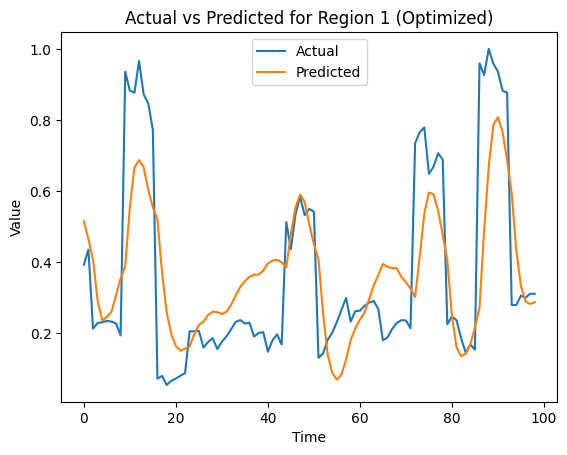

In [3]:
data['Datetime'] = pd.to_datetime(data['Unnamed: 0'], dayfirst=True)
data.set_index('Datetime', inplace=True)
data.drop(columns=['Unnamed: 0'], inplace=True)

#scaling
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Convert data into sequences
def create_sequences(dataset, time_step=10):
    X, y = [], []
    for i in range(len(dataset) - time_step - 1):
        X.append(dataset[i:(i + time_step), :])
        y.append(dataset[i + time_step, :])
    return np.array(X), np.array(y)

time_step = 10
X, y = create_sequences(scaled_data, time_step)

# training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# LSTM model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(time_step, 33)),
    Dropout(0.3),  # Increased
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(33)  # Output layer for 33 regions
])

# Compile the model for the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Callbacks for optimization
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr], verbose=1)

# Making predictions
predictions = model.predict(X_test)

# Inverse transform predictions to get actual values
predictions_rescaled = scaler.inverse_transform(predictions)

model.save('optimized_smart_grid_model.h5')

# To visualize predictions vs actual values
import matplotlib.pyplot as plt

plt.plot(y_test[:, 0], label="Actual")  #  for the first region
plt.plot(predictions[:, 0], label="Predicted")
plt.title('Actual vs Predicted for Region 1 (Optimized)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()